In [3]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [ ]:
import importlib
importlib.reload(c3)

In [4]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [5]:
# Read the fits file and save header
HI_cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss.fits')
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv)) #/10 to nm

(4300, 52, 58)


(0.0, 2.5e-15)

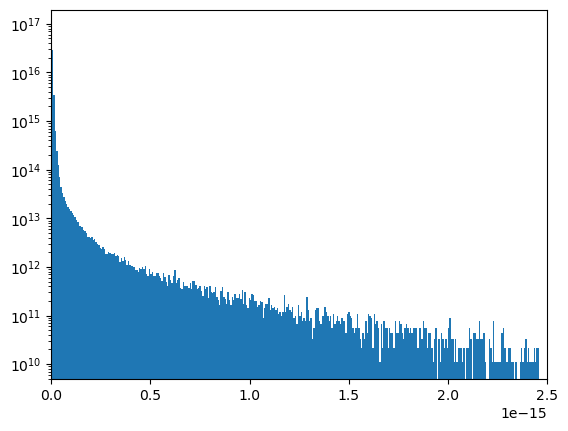

In [14]:
plt.hist(HI_cube.unmasked_data[:].to_value().flatten(), bins=400, density=True)
plt.yscale('log')
plt.xlim(0,2.5e-15)

In [6]:
#define isoleves in mJy/beam
#isolevels = np.array([1.5, 2.5, 3.5, 6]) #hcg91
#isolevels = np.array([1.5, 4.5, 8.5, 13]) #hcg16
#isolevels = np.array([1.5, 3.5, 6.5, 11]) #hcg31
isolevels = np.array([2, 5, 9, 13, 18])

In [9]:
c3.preview2d(HI_cube)

TypeError: allbadtonan.<locals>.f() got an unexpected keyword argument 'out'

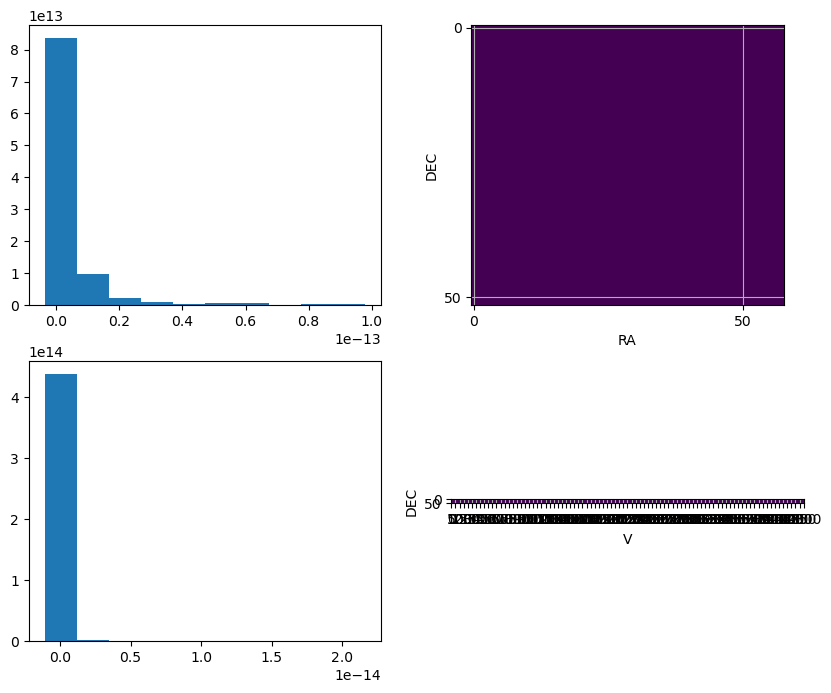

In [10]:
c3.preview2d(HI_cube.unmasked_data[:].to_value(), vmin1=0.006, vmax1=0.03, vmin2=0.01, vmax2=0.07, norm='asinh')

In [11]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [5]:
#HCG31
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [60, nx-61]
limy = [100, ny-91]
limz = [90, nz-81]

In [ ]:
#HCG16
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [80, nx-16]
limy = [50, ny-11]
limz = [0, nz-1]

In [ ]:
#HCG91
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [100, nx-101]
limy = [100, ny-81]
limz = [10, nz-11]

In [7]:
#borja MRB
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [3450, nz-111]

In [8]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('nm').to_value()

In [9]:
def transpose(array, delta):
    dra, ddec, dv = delta
    return np.transpose(array, (2,1,0))[::int(np.sign(dra)), ::int(np.sign(ddec)),::int(np.sign(dv))]

In [10]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value() *10**16
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = transpose(HI_cube, (dra,ddec,dv))

In [11]:
# Save new dimensions
nx_2, ny_2, nz_2 = HI_cube.shape
print(HI_cube.shape)

(58, 52, 740)


In [10]:
c = '0 0 1'
# HCG31 all from LVM et al. (2005)
gals = {'HCG31a':{'v':4090,'col':c},
       'HCG31b':{'v':4122,'col':c},
       'HCG31c':{'v':3984,'col':c},
        'HCG31g':{'v':4005,'col':c},
        'HCG31q':{'v':4090,'col':c}
       }

In [ ]:
c = '0 0 1'
# HCG16 from Hickson 1992
gals = {'HCG16a':{'v':4152,'col':c},
       'HCG16b':{'v':3977,'col':c},
       'HCG16c':{'v':3851,'col':c},
        'HCG16d':{'v':3847,'col':c},
        'NGC848':{'v':4001, 'col':c}
       }

In [ ]:
c = '0 0 1'
# HCG91 from Hickson 1992
gals = {'HCG91a':{'v':6832,'col':c},
       'HCG91b':{'v':7196,'col':c},
       'HCG91c':{'v':7319,'col':c},
        'HCG91d':{'v':7195,'col':c}
       }

In [ ]:
for (k,gal) in enumerate(gals.keys()):

    # Go from RA/Dec -> rescaled pixel space !
    coords = SkyCoord.from_name(gal)
    #coords = SkyCoord(gals[gal]['ra'], gals[gal]['dec'])
    #pixcrd = coords.to_pixel(w,1)
    
    coords.ra.deg = (coords.ra.deg-ramean.to_value())*np.cos(np.radians(declim[0]))*3600
    coords.dec.deg = (coords.dec.deg-decmean.to_value())*3600.

    gals[gal]['coord'] = np.array([coords.ra.deg, coords.dec.deg, gals[gal]['v']-vmean])

In [12]:
coords = np.array([ralim, declim, vlim])

In [17]:
color = c3.create_colormap('CMRmap', isolevels)

In [24]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers',
        'description':'HI data cube of %s'%cubehead['OBJECT']
       }

In [19]:
x3dname = 'borja_3.x3d'

In [20]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec,
                    coords, header=cubehead, units=["e16 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], meta=None, picking=False)

#also need html.func_pick() if picking=True

[[ -6.10790397   0.           6.10790397]
 [ -5.4672       0.           5.4672    ]
 [-40.645        0.          40.645     ]]


In [ ]:
survey = ['DSS2 Blue']
verts = (coords[0,0], coords[0,1], coords[1,0], coords[1,1])
imcol, img_shape, img = c3.get_imcol(position='HCG16', survey=survey, verts=verts,
                                     unit='deg', pixels='2500,2500',
                         coordinates='J2000',grid=True, gridlabels=True)

In [21]:
file.make_layers(HI_cube, isolevels, color)
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
#file.make_image2d(imcol, img_shape)
file.make_ticklines()
file.make_labels(gals=None, axlab='both') 
# html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [22]:
tabtitle = 'optical'
pagetitle = 'optical interactive datacube with X3D'
# add in desc for 2d image: <br>\n\t Background image: {survey}
#desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}. RestFreq = {cubehead['RESTFREQ']/1e6:.4f} MHz.<br>\n\t Center: (RA,Dec,V)=({np.round(ramean,5)}, {np.round(decmean,5)}, {np.round(vmean,3)} km/s)"

In [23]:
colmaps = ['magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [24]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], 
                    units=["e16 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=None)

In [25]:
html.func_layers(len(isolevels))
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('both')
#html.func_pick() #for coordinate picking
html.start_x3d()
html.viewpoints(maxco=(file.diff_coords[0,2], file.diff_coords[1,2]),
                vrad=file.diff_coords[2])
html.close_x3d(x3dname)
html.buttons(isolevels, colormaps=colmaps, hide2d=False, scalev=True, move2d=False)
#func_move2dimage, func_colormaps and func_scalev must always go after buttons
#html.func_image2d(vmax=file.diff_coords[2,2], scalev=True)
html.func_colormaps(isolevels)
html.func_scalev(len(isolevels), gals=None, axes='both', coords=file.diff_coords, vmax=None)
#html.func_move2dimage(vmax=file.diff_coords[2,2])
html.close_html()